# Install pytorch


- https://pytorch.org/

1. Go to anaconda terminal as admin and enter
```bash
conda create --name pytorch_cpu python=3.12
```

2. activate environment

```bash
conda activate pytorch_cpu
```

3. install pytorch
```bash 

# CPU Only Windows and Linux
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 cpuonly -c pytorch

# MAC OSX
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 -c pytorch

```

4. install additional packages from dslabs and data functions
```bash
conda install pandas scikit-learn matplotlib statsmodels
```

5. if jupyter has errors run

```bash
conda install -n pytorch_cpu ipykernel --update-deps --force-reinstall
```



In [1]:
import torch
print(torch.__version__)

2.5.0


# DSLabs functions

In [1]:
%run "scripts/dslabs_functions.py"


In [2]:
import sys
sys.path.append('scripts')

from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

# Data functions

In [ ]:
%run "scripts/data_functions.py"

ModuleNotFoundError: No module named 'seaborn'

# Load

In [11]:
import pandas as pd
test_data=False
# test_data=False


file_tag = "Gira Bike"


train=pd.read_csv(f"data/df_gira_agg_2h_final_train.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"data/df_gira_agg_2h_final_test.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
target='target_station_load_rate'
# Se os dados já tiverem a frequência correta para cada dia (com todas as horas), 
# podemos apenas ajustar o índice para começar no horário correto.
#
#train.index = pd.date_range(start='2022-01-01 14:00', periods=len(train), freq='2H')
#test.index = pd.date_range(start='2023-02-14 16:00', periods=len(test), freq='2H')



test_split_threshold=0.9
# Prepare the training and testing data from dataframes with features and target
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]


from numpy import arange

# Ensure no data leakage
assert not set(train.index).intersection(set(test.index)), "Data leakage detected: Train and test sets overlap."


train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4878 entries, 2022-01-01 14:00:00 to 2023-02-14 14:00:00
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   temperature_2m                                               4878 non-null   float64
 1   rain_mm                                                      4878 non-null   float64
 2   wmo_weather_code                                             4878 non-null   float64
 3   wind_speed_10m                                               4878 non-null   float64
 4   is_holiday_lisbon                                            4878 non-null   float64
 5   target_station_status                                        4878 non-null   float64
 6   target_station_load_rate                                     4878 non-null   float64
 7   station_load_rate_ Rua do Arco Cego / Av. 

# LSTM Pytorch Univariate

## Univariate Pytorch Functions and data prep

In [48]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm_uni(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM_Univariate(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm_uni(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [49]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study_uni(train, test, nr_episodes: int = 1000, sequence_size: list =[2,4,8], nr_hidden_units: list =[25,50,100], measure: str = "R2"):
    # sequence_size = [2, 4, 8]
    # nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm_uni(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM_Univariate(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Univariate Pytorch Study

seq length=1 hidden_units=5 nr_episodes=0 -0.20996034145355225
seq length=1 hidden_units=5 nr_episodes=5 -0.11765038967132568
seq length=1 hidden_units=5 nr_episodes=10 -0.057155489921569824
seq length=1 hidden_units=5 nr_episodes=15 -0.02672100067138672
seq length=1 hidden_units=5 nr_episodes=20 -0.014521241188049316
seq length=1 hidden_units=5 nr_episodes=25 -0.011775970458984375
seq length=1 hidden_units=5 nr_episodes=30 -0.00587618350982666
seq length=1 hidden_units=5 nr_episodes=35 -0.0038300752639770508
seq length=1 hidden_units=5 nr_episodes=40 -0.003505110740661621
seq length=1 hidden_units=5 nr_episodes=45 0.0003859996795654297
seq length=1 hidden_units=5 nr_episodes=50 0.0010939240455627441
seq length=1 hidden_units=15 nr_episodes=0 -0.040491342544555664
seq length=1 hidden_units=15 nr_episodes=5 -0.011197805404663086
seq length=1 hidden_units=15 nr_episodes=10 -0.005820512771606445
seq length=1 hidden_units=15 nr_episodes=15 0.003884613513946533
seq length=1 hidden_units=15 

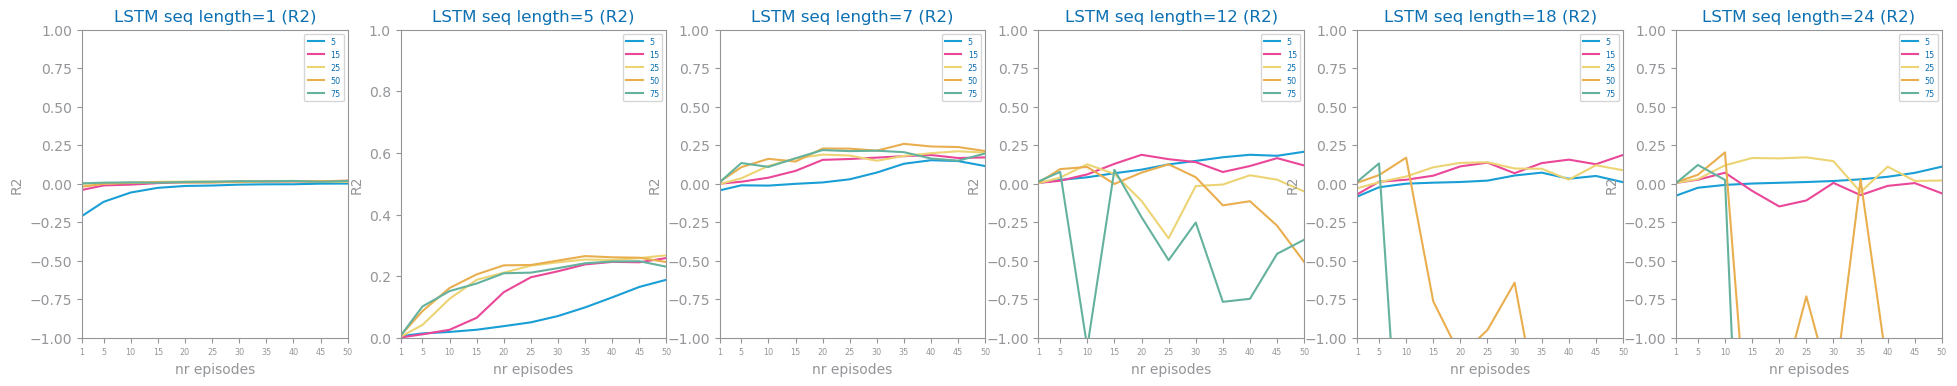

In [50]:
# # Prepare the training and testing data using the time index as the feature
from numpy import arange


train_series_float = train[[target]].values.astype("float32")
test_series_float = test[[target]].values.astype("float32")


best_model, best_params = lstm_study_uni(train_series_float, test_series_float, nr_episodes=50,sequence_size=[1,5,7,12,18,24],nr_hidden_units=[5,15,25,50,75], measure='R2')

## Univariate Pytorch eval

In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import Series
from matplotlib import pyplot as plt

def plot_single_model_evaluation(train: Series, test: Series, prd_train: Series, prd_test: Series, title: str = ""):
    # Calculate performance metrics
    metrics = {
        "MAE": [
            mean_absolute_error(train, prd_train),
            mean_absolute_error(test, prd_test),
        ],
        "MSE": [
            mean_squared_error(train, prd_train),
            mean_squared_error(test, prd_test),
        ],
        "RMSE": [
            np.sqrt(mean_squared_error(train, prd_train)),
            np.sqrt(mean_squared_error(test, prd_test)),
        ],
        "R²": [
            r2_score(train, prd_train),
            r2_score(test, prd_test),
        ]
    }

    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics, index=["Train", "Test"]).T
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    scale_dependent_data = performance_df.loc[scale_dependent_errors]
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_errors = ["R²"]
    percentage_data = performance_df.loc[percentage_errors]
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



def plot_performance_metrics(metrics: dict, title: str = ""):
    # Create a DataFrame from the metrics dictionary
    performance_df = pd.DataFrame(metrics)
    
    # Separate scale-dependent errors and percentage errors
    scale_dependent_errors = ["MAE", "MSE", "RMSE"]
    percentage_errors = ["R²"]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)
    
    # Plot scale-dependent errors
    scale_dependent_data = performance_df[["Model"] + scale_dependent_errors].set_index("Model").T
    ax = axs[0]
    ax.set_title("Scale-dependent errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.2  # Adjusted bar width for more spacing
    index = np.arange(len(scale_dependent_data.columns))
    for i, metric in enumerate(scale_dependent_data.index):
        bars = ax.bar(index + i * bar_width * 1.5, scale_dependent_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(scale_dependent_data.columns)
    ax.legend()
    
    # Plot percentage errors
    percentage_data = performance_df[["Model"] + percentage_errors].set_index("Model").T
    ax = axs[1]
    ax.set_title("Percentage errors")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    bar_width = 0.35
    index = np.arange(len(percentage_data.columns))
    for i, metric in enumerate(percentage_data.index):
        bars = ax.bar(index + i * bar_width, percentage_data.loc[metric], bar_width, label=metric)
        ax.bar_label(bars, fmt='%.2f')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentage_data.columns)
    ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

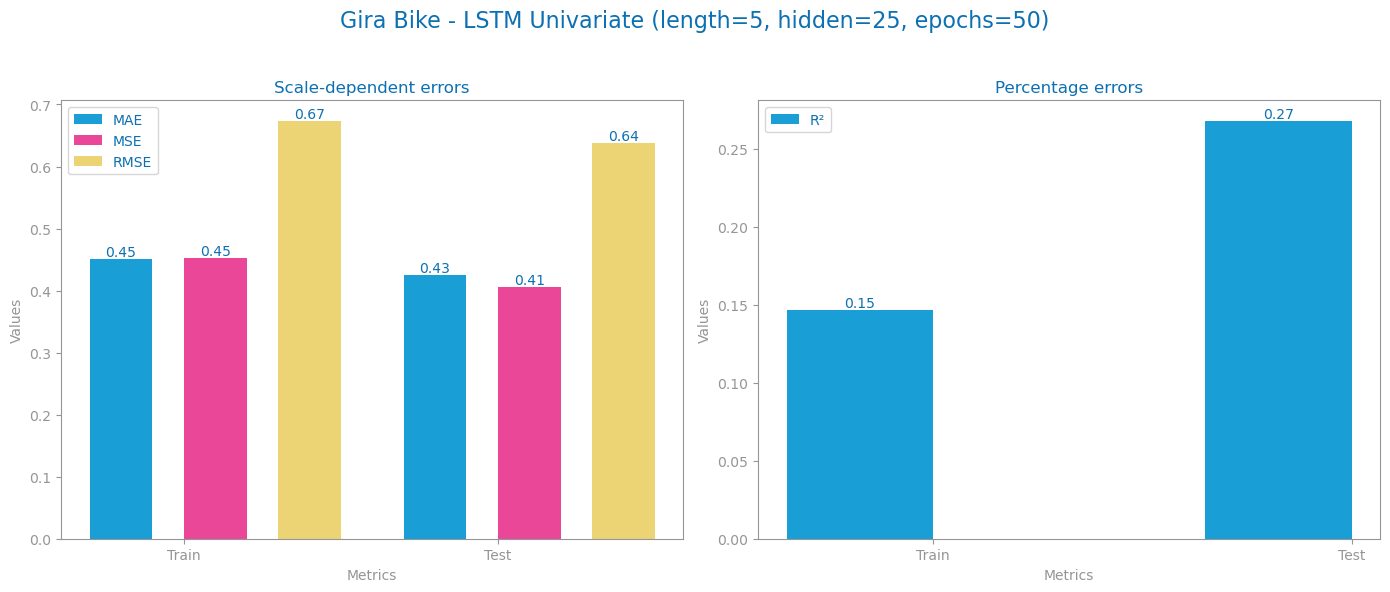

In [52]:

params = best_params["params"]
best_length = params[0]


# Assuming train and test are DataFrames with a DateTime index
trn_series = train[[target]]
tst_series = test[[target]]


trnX, trnY = prepare_dataset_for_lstm_uni(trn_series.values.astype("float32"), seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm_uni(tst_series.values.astype("float32"), seq_length=best_length)


prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Plot the forecasting evaluation
plot_single_model_evaluation(trn_series[best_length:], tst_series[best_length:], prd_trn, prd_tst, title=f"{file_tag} - LSTM Univariate (length={best_length}, hidden={params[1]}, epochs={params[2]})")

## Plot lstm tensorflow model univariate

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

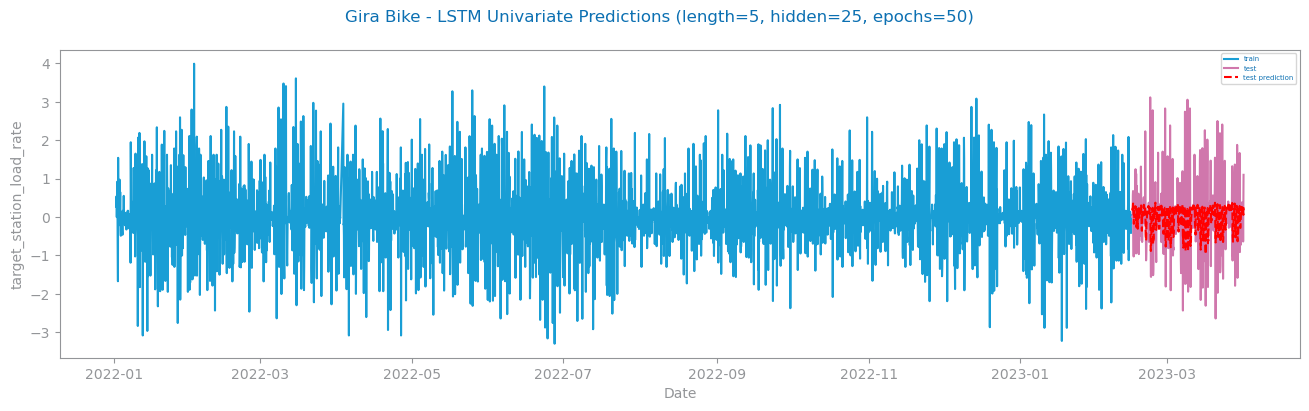

In [53]:
from pandas import Series
pred_series = Series(prd_tst.numpy().ravel(), index=tst_series.index[best_length:])


plot_forecasting_series(
    trn_series[best_length:],
    tst_series[best_length:],
    pred_series,
    title=f"{file_tag} - LSTM Univariate Predictions (length={best_length}, hidden={params[1]}, epochs={params[2]})",
    xlabel='Date',
    ylabel=target,
)

## Pytorch Univariate Model and Loss

In [54]:
model = DS_LSTM_Univariate(train_series_float, input_size=train_series_float.shape[1], hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.1638, grad_fn=<MseLossBackward0>)


## Analysis - Results from Model Implementation

# LSTM Pytorch Multivariate

## Pytorch Multivariate Functions

In [4]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def prepare_dataset_for_lstm_multi(features, target, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(target) - seq_length):
        past = features[i : i + seq_length]
        future = target[i + seq_length]  # Predict the next value only
        setX.append(past)
        setY.append(future)
    setX = tensor(np.array(setX, dtype=np.float32))  # Convert to torch.float32
    setY = tensor(np.array(setY, dtype=np.float32)).view(-1, 1)  # Convert to torch.float32 and reshape
    return setX, setY


class DS_LSTM_Multivariate(Module):
    def __init__(self, trainX, trainY, input_size: int, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm_multi(trainX, trainY, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(trainX) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # Use the last output of the LSTM
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred

from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

def lstm_study_multi(trainX, trainY, testX, testY, nr_episodes: int = 1000,sequence_size: list =[2,4,8], nr_hidden_units: list =[25,50,100], measure: str = "R2"):
    # sequence_size = [2, 4, 8]
    # nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm_multi(testX, testY, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM_Multivariate(trainX, trainY, input_size=trainX.shape[1], hidden_size=hidden, length=length)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](testY[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Pytorch Multivariate Data Study

seq length=1 hidden_units=5 nr_episodes=0 -0.12162613868713379
seq length=1 hidden_units=5 nr_episodes=5 -0.030221223831176758
seq length=1 hidden_units=5 nr_episodes=10 0.006277620792388916
seq length=1 hidden_units=5 nr_episodes=15 0.019394874572753906
seq length=1 hidden_units=5 nr_episodes=20 0.02467978000640869
seq length=1 hidden_units=5 nr_episodes=25 0.028925538063049316
seq length=1 hidden_units=5 nr_episodes=30 0.03148716688156128
seq length=1 hidden_units=5 nr_episodes=35 0.03242725133895874
seq length=1 hidden_units=5 nr_episodes=40 0.03406292200088501
seq length=1 hidden_units=5 nr_episodes=45 0.03606611490249634
seq length=1 hidden_units=5 nr_episodes=50 0.03750264644622803
seq length=1 hidden_units=15 nr_episodes=0 -0.026136279106140137
seq length=1 hidden_units=15 nr_episodes=5 -0.005013465881347656
seq length=1 hidden_units=15 nr_episodes=10 0.00817042589187622
seq length=1 hidden_units=15 nr_episodes=15 0.022160708904266357
seq length=1 hidden_units=15 nr_episodes=20 

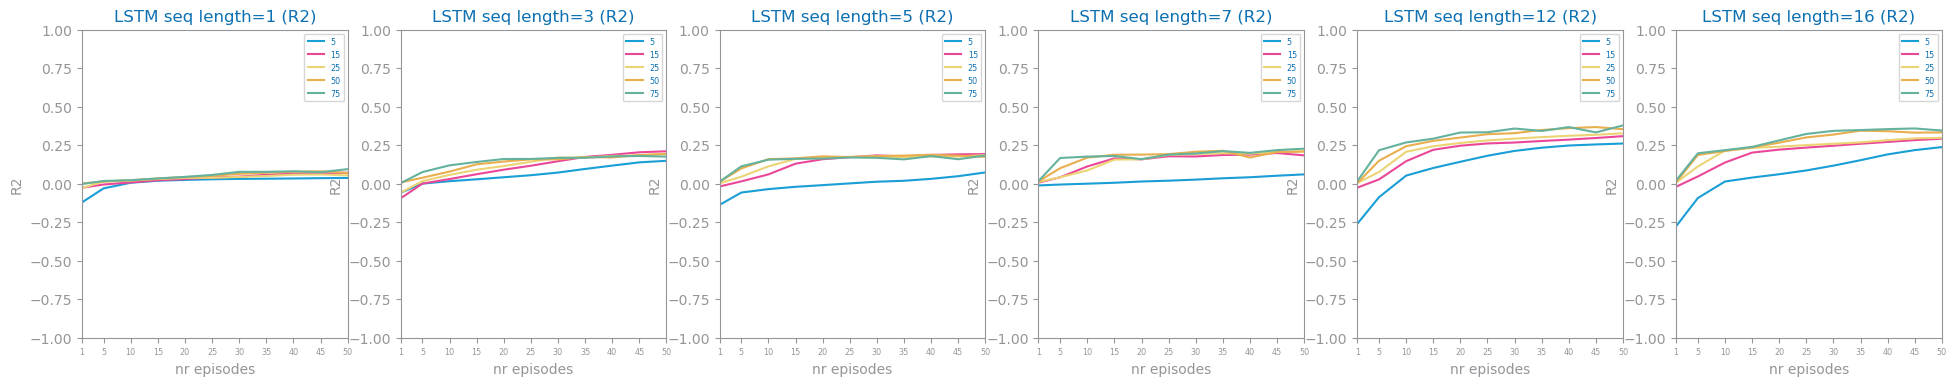

In [5]:
# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY_float = train.pop(target).values.astype(np.float32)
tstY_float = test.pop(target).values.astype(np.float32)
trnX_float = train.values.astype(np.float32)
tstX_float = test.values.astype(np.float32)

# Run the study
best_model, best_params = lstm_study_multi(trnX_float,
                                           trnY_float,
                                           tstX_float,
                                           tstY_float,
                                           nr_episodes=50,
                                           sequence_size=[1,3,5,7,12,16],
                                           nr_hidden_units=[5,15,25,50,75],
                                           measure='R2')

## Pytorch Multivariate Model Evaluation

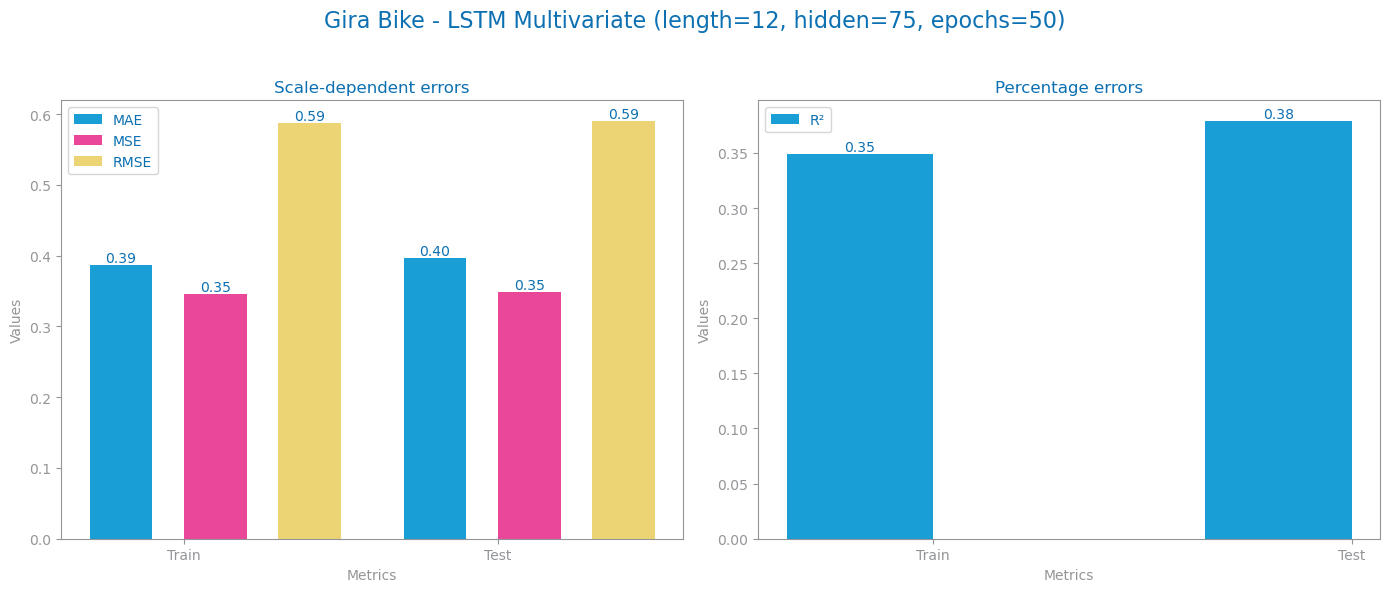

<Figure size 640x480 with 0 Axes>

In [8]:

params = best_params["params"]
best_length = params[0]


train=pd.read_csv(f"data/df_gira_agg_2h_final_train.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
test=pd.read_csv(f"data/df_gira_agg_2h_final_test.csv", decimal=".",  index_col='date', parse_dates=True,  infer_datetime_format=True)
target='target_station_load_rate'


# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY_float = train.pop(target).values.astype(np.float32)
tstY_float = test.pop(target).values.astype(np.float32)
trnX_float = train.values.astype(np.float32)
tstX_float = test.values.astype(np.float32)


trnX, trnY = prepare_dataset_for_lstm_multi(trnX_float, trnY_float, seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm_multi(tstX_float, tstY_float, seq_length=best_length)


prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)


# Assuming train and test are DataFrames with a DateTime index
# Reconstruct the series for plotting
train[target] = trnY_float
test[target] = tstY_float
trn_series = train[[target]]
tst_series = test[[target]]


# Plot the forecasting evaluation
plot_single_model_evaluation(trn_series[best_length:], tst_series[best_length:], prd_trn, prd_tst, title=f"{file_tag} - LSTM Multivariate (length={best_length}, hidden={params[1]}, epochs={params[2]})")
savefig(f"images/{file_tag}_LSTM_multivariate_predictions.png")

## Pytorch Multivariate Plots

<Axes: xlabel='Date', ylabel='target_station_load_rate'>

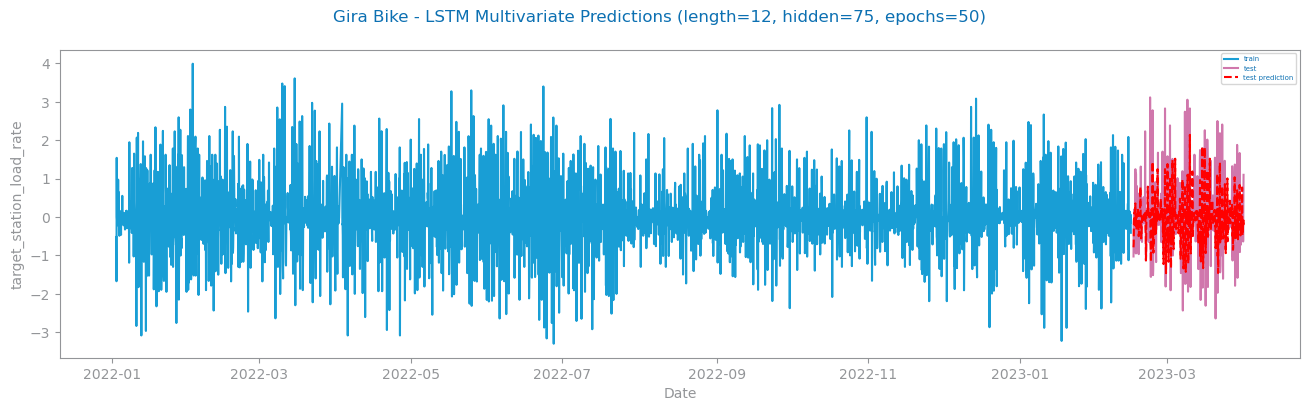

In [9]:
from pandas import Series
pred_series = Series(prd_tst.numpy().ravel(), index=tst_series.index[best_length:])


plot_forecasting_series(
    trn_series[best_length:],
    tst_series[best_length:],
    pred_series,
    title=f"{file_tag} - LSTM Multivariate Predictions (length={best_length}, hidden={params[1]}, epochs={params[2]})",
    xlabel='Date',
    ylabel=target,
)

## Pytorch Multivariate Model and Loss

In [10]:
model = DS_LSTM_Multivariate(trnX_float, trnY_float, input_size=trnX_float.shape[1], hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.0697, grad_fn=<MseLossBackward0>)


## Analysis - Results from Model Implementation